# <font color="dark">Image preprocessing</font>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import os
%matplotlib inline

### <font color="blue">Test data</font>

In [2]:
img_df = pd.read_csv('../data/train_clean_df.csv')

### <font color="blue">Show the original image</font>

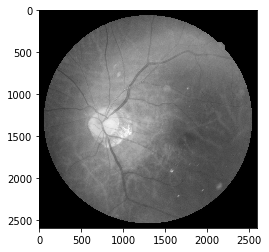

In [3]:
img = cv2.imread(img_df.iloc[1200].file)
img_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_GRAY = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img_GRAY,cmap="gray")

### <font color="blue">Make the Mask for image</font>

#### preprocessing 

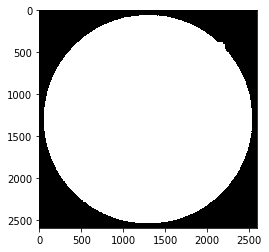

In [4]:
test_img = img_GRAY.copy()

# 二值化
ret, thresh = cv2.threshold(test_img, 10, 255, cv2.THRESH_BINARY)

# Morphological transformation (去雜訊)
kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

plt.imshow(closing, cmap="gray")

#### Define the size of the mask

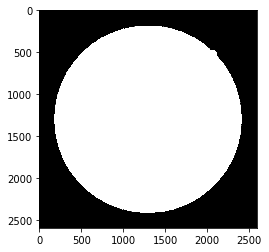

In [5]:
resizing_szie = (int(round(closing.shape[0]*0.9, -1)), int(round(closing.shape[0]*0.9, -1)))
resizing_img = cv2.resize(closing, resizing_szie)
background = np.zeros([img_GRAY.shape[0],img_GRAY.shape[1]])

# Pasting image
## 圖片貼上的起始位置
x_loc = int((closing.shape[0] - resizing_img.shape[0])/2)
y_loc = int((closing.shape[1] - resizing_img.shape[1])/2)

## 圖片貼上的最終位置
x_end = x_loc + resizing_img.shape[1]
y_end = y_loc + resizing_img.shape[0]

## Pasting
background[ y_loc:y_end, x_loc:x_end ] = resizing_img
mask = background.astype(np.uint8)  # 用 uint 8 才能使用 bitwise 參數

plt.imshow(mask,cmap='gray')

### <font color="blue">Gassium filter</font>

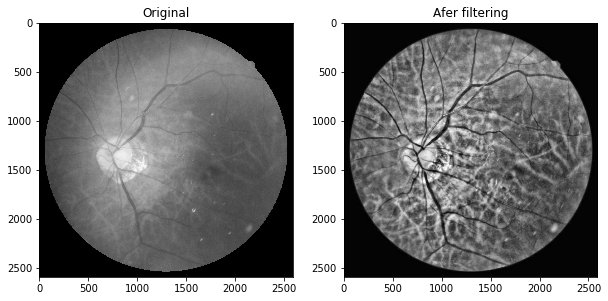

In [6]:
# Gassium filter
blur = cv2.GaussianBlur(test_img,(71,71),3)

plt.figure(figsize=(10,16))
plt.subplot(1,2,1)
plt.imshow(img_GRAY, cmap='gray')
plt.title("Original")

plt.subplot(1,2,2)
# blur = np.sqrt(np.float32(blur[1:blur.shape[0], 0:blur.shape[1]-1]) - np.float32(blur[0:blur.shape[0]-1, 0:blur.shape[1]-1])) + (np.float32(blur[0:blur.shape[0]-1, 1:blur.shape[1]] - np.float32(blur[0:blur.shape[0]-1, 0:blur.shape[1]-1]))) ** 2 
# blur = np.float32(blur) / np.float32(np.max(blur)) * 255.
clahe = cv2.createCLAHE(clipLimit=8,tileGridSize=(30,30))
blur = clahe.apply(blur)
plt.imshow(np.uint8(blur), cmap='gray')
plt.title("Afer filtering")

plt.show()

### <font color="blue">Combine the filter and the mask</font>

In [7]:
print(f'blur : {blur.shape}\n mask : {mask.shape}')

blur : (2592, 2592)
 mask : (2592, 2592)


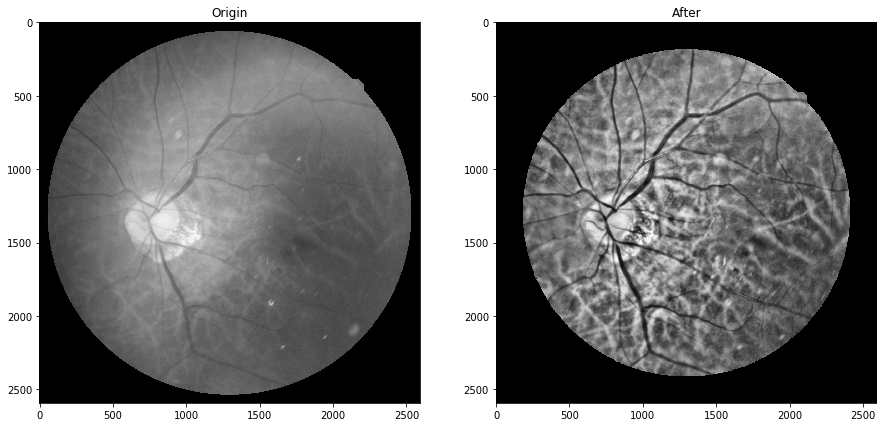

In [8]:
# Combine
test = cv2.bitwise_or(blur,blur,mask=mask)

plt.figure(figsize=(15,20))

plt.subplot(1,2,1)
plt.title("Origin")
plt.imshow(test_img, cmap='gray')

plt.subplot(1,2,2)
plt.title('After')
plt.imshow(test, cmap='gray')

## <font color='dark'>Step 3 : Write to the function</font>

In [9]:
def image_preprocessing(img_GRAY):
    # Building Mask
    ## 二值化
    ret, thresh = cv2.threshold(img_GRAY, 10, 255, cv2.THRESH_BINARY)

    ## Morphological transformation (去雜訊)
    kernel = np.ones((5,5),np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    ## Resize the image
    resizing_szie = (int(round(closing.shape[0]*0.9, -1)), int(round(closing.shape[0]*0.9, -1)))
    resizing_img = cv2.resize(closing, resizing_szie)
    background = np.zeros([img_GRAY.shape[0],img_GRAY.shape[1]])

    ## Pasting image
    ### 圖片貼上的起始位置
    x_loc = int((closing.shape[0] - resizing_img.shape[0])/2)
    y_loc = int((closing.shape[1] - resizing_img.shape[1])/2)

    ### 圖片貼上的最終位置
    x_end = x_loc + resizing_img.shape[1]
    y_end = y_loc + resizing_img.shape[0]

    ## Pasting
    background[ y_loc:y_end, x_loc:x_end ] = resizing_img
    mask = background.astype(np.uint8)  # 用 uint 8 才能使用 bitwise 參數
    
    # Image processing
    ## Gassium filter
    blur = cv2.GaussianBlur(img_GRAY,(71,71),3)
    
    ## 直方圖均衡化(CLAHE)
    clahe = cv2.createCLAHE(clipLimit=8,tileGridSize=(30,30))
    blur = clahe.apply(blur)
    
    # Combine
    Final = cv2.bitwise_or(blur,blur,mask=mask)
    return Final

In [10]:
img_df = pd.read_csv('../data/train_clean_df.csv')

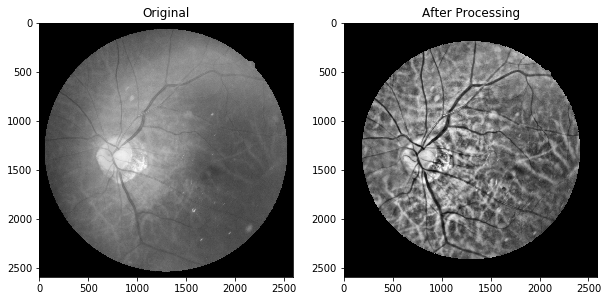

In [35]:
test = cv2.imread(img_df.iloc[1200].file)
test_gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(test_gray, cmap='gray')
plt.subplot(1,2,2)
plt.title("After Processing")
plt.imshow(image_preprocessing(test_gray), cmap='gray')
plt.show()

In [30]:
def rotate_img(image, angle):
    cols, rows = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst

In [34]:
def Brightness_and_contrast(image, contrast, brightness):
    new_image = np.zeros(image.shape, image.dtype)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            new_image[y,x] = np.clip(contrast*image[y,x] + brightness, 0, 255)
    return new_image

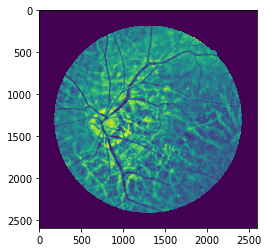

In [37]:
test_bc = image_preprocessing(test_gray)
plt.imshow(Brightness_and_contrast(test_bc, 0.8, 30))